In [1]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/x_y_dataset.csv")

In [2]:
df = df.drop(df.index[0:22])
df.head(24)


,lemmatized,Etiket
22,"['da', 'orospu', 'cocuklari', 'hep', 'diye', '...",nefret
23,"['ciddi', 'ol', 'tüm', 'dünya', 'beyn', 'bil',...",saldırgan
24,"['kayıt', 'istihdam', 'geniş', 'program', 'gör...",hiçbiri
25,"['hastane', 'ait', 'suriye', 'ptt', 've', 'ait...",nefret
26,"['köle', 'git', 'suriye', 'gibi', 'bugün']",hiçbiri
27,"['çocuk', 'sadece', 'türkiye', 'değil', 'ırak'...",hiçbiri
28,"['suriye', 'ol', 'bil', 'httpstcodknrytjfxt']",hiçbiri
29,"['keşke', 'sadece', 'suriye', 'çalış', 'işvere...",hiçbiri
30,"['izin', 'suriye', 'afgan', 'pakistan', 'polit...",hiçbiri
31,"['ülke', 'büyükelçi', 'dahil', 'suriye', 'iste']",nefret


In [3]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import numpy as np


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:

# Metinleri kelime listelerine bölme
sentences = [text.split() for text in df['lemmatized']]

# Word2Vec modelini tanımlama ve eğitme
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

# Kelime vektörlerini alma
word_vectors = word2vec_model.wv
vector_size = 100

# Metinleri Word2Vec vektörlerine dönüştürme
def vectorize_text(text, model, vector_size):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Tüm metinleri vektörleştirme
X = np.array([vectorize_text(text, word_vectors, vector_size) for text in df['lemmatized']])


In [5]:
# Hedef değişkeni (y) sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Etiket'])

# Sınıf dönüşüm haritasını yazdırma
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Class mapping: {'hiçbiri': 0, 'nefret': 1, 'saldırgan': 2}


In [6]:
# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE ile veri dengeleme
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# SMOTETomek ile veri dengeleme
smote_tomek = SMOTETomek(random_state=42)
X_smotetomek, y_smotetomek = smote_tomek.fit_resample(X_train, y_train)

# RandomUnderSampler ile veri dengeleme
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

# Resampling yöntemlerini listeleme
resampling_methods = {
    "Original": (X_train, y_train),
    "SMOTE": (X_smote, y_smote),
    "SMOTETomek": (X_smotetomek, y_smotetomek),
    "RandomUnderSampler": (X_undersampled, y_undersampled)
}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

In [7]:
# Modelleri tanımlama
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Artificial Neural Network (ANN)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}


In [8]:
# Performans sonuçları için tablo oluşturma
results = []

for method_name, (X_resampled, y_resampled) in resampling_methods.items():
    for model_name, model in models.items():
        # Modeli eğitme
        model.fit(X_resampled, y_resampled)

        # Test verilerinde tahmin
        y_pred = model.predict(X_test)

        # Performans metriklerini hesaplama
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # Sonuçları tabloya ekleme
        results.append({
            "Resampling Method": method_name,
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

# Sonuçları DataFrame olarak gösterme
results_df = pd.DataFrame(results)
print(results_df)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 100
[LightGBM] [Info] Start training from score -0.280737
[LightGBM] [Info] Start training from score -1.476166
[LightGBM] [Info] Start training from score -4.118976


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:06:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 18525, number of used features: 100
[LightGBM] [Info] Start training from score -1.098774
[LightGBM] [Info] Start training from score -1.098774
[LightGBM] [Info] Start training from score -1.098288


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:08:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13366
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


     Resampling Method                            Model  Accuracy  Precision  \
0             Original              Logistic Regression  0.801467   0.772400   
1             Original                    Random Forest  0.804401   0.792168   
2             Original                          XGBoost  0.815648   0.790708   
3             Original                         LightGBM  0.819071   0.795549   
4             Original  Artificial Neural Network (ANN)  0.801467   0.794359   
5                SMOTE              Logistic Regression  0.644010   0.798082   
6                SMOTE                    Random Forest  0.801467   0.781688   
7                SMOTE                          XGBoost  0.815648   0.801994   
8                SMOTE                         LightGBM  0.801467   0.797608   
9                SMOTE  Artificial Neural Network (ANN)  0.798044   0.791519   
10          SMOTETomek              Logistic Regression  0.641565   0.796361   
11          SMOTETomek                  

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
results_df


,Resampling Method,Model,Accuracy,Precision,Recall,F1-Score
0,Original,Logistic Regression,0.801467,0.772400,0.801467,0.774705
1,Original,Random Forest,0.804401,0.792168,0.804401,0.761088
2,Original,XGBoost,0.815648,0.790708,0.815648,0.793229
3,Original,LightGBM,0.819071,0.795549,0.819071,0.794549
4,Original,Artificial Neural Network (ANN),0.801467,0.794359,0.801467,0.796858
5,SMOTE,Logistic Regression,0.644010,0.798082,0.644010,0.703581
6,SMOTE,Random Forest,0.801467,0.781688,0.801467,0.789503
7,SMOTE,XGBoost,0.815648,0.801994,0.815648,0.807828
8,SMOTE,LightGBM,0.801467,0.797608,0.801467,0.799497
9,SMOTE,Artificial Neural Network (ANN),0.798044,0.791519,0.798044,0.794579


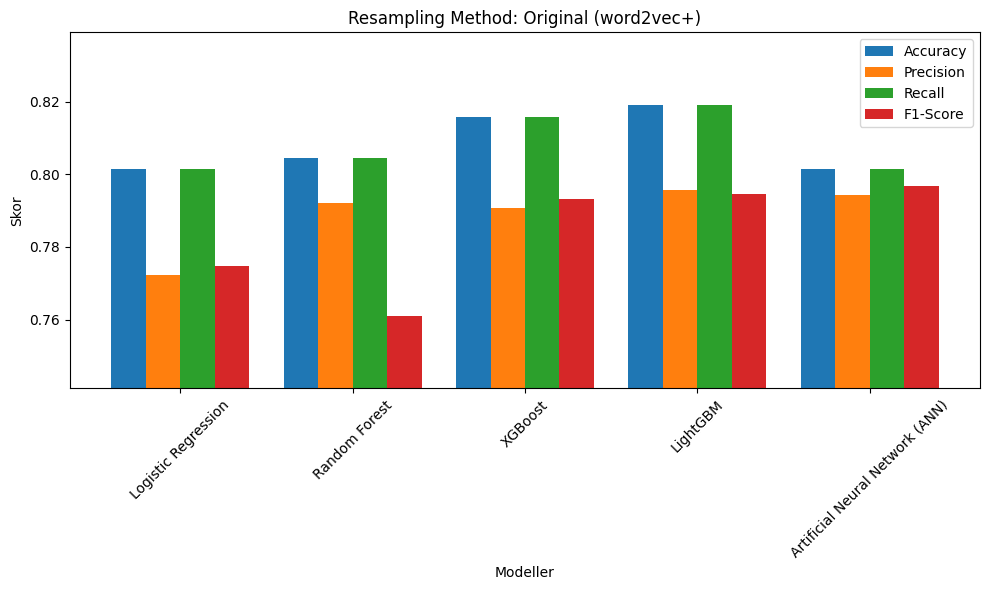

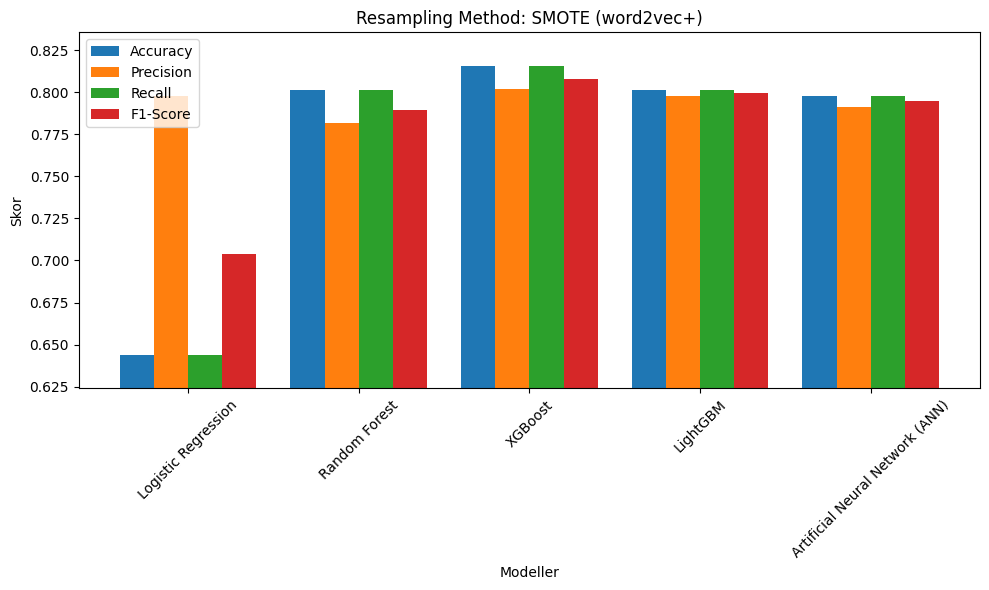

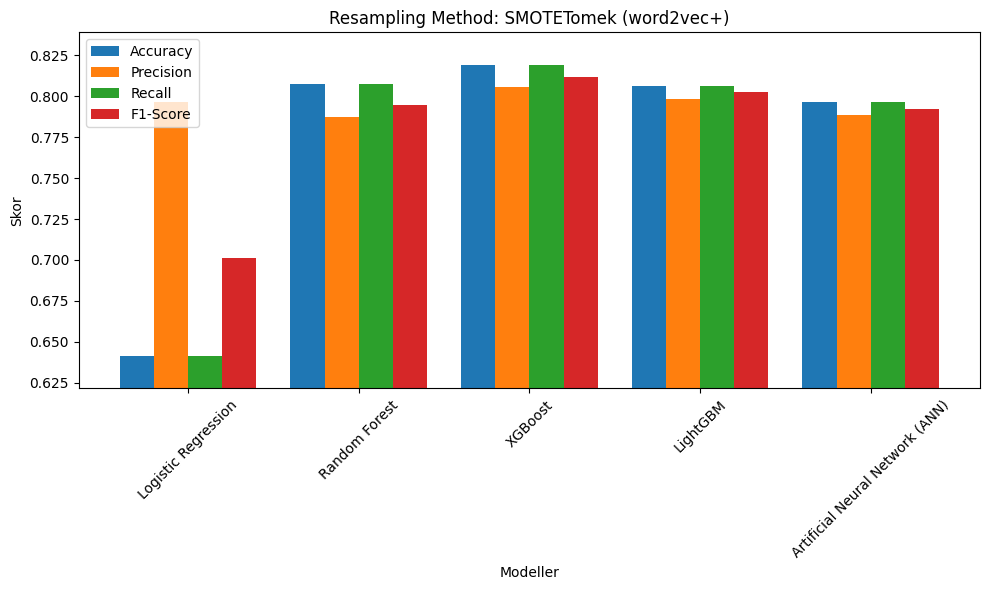

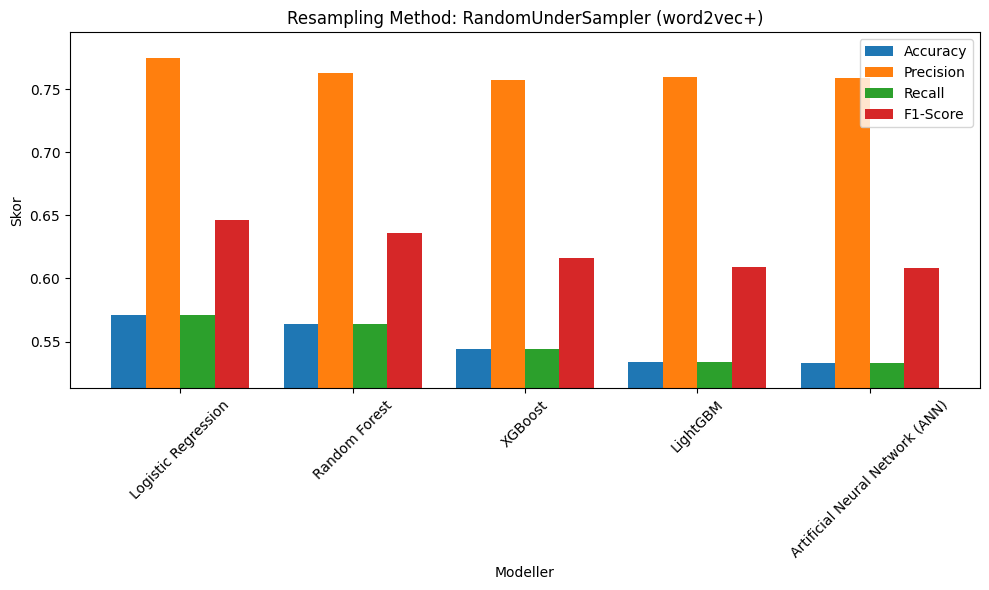

In [13]:
import matplotlib.pyplot as plt

# Resampling yöntemleri, modeller ve metrikler
methods = results_df['Resampling Method'].unique()
model_names = results_df['Model'].unique()
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

for method in methods:
    # Bu yönteme ait tüm satırları filtrele
    method_data = results_df[results_df['Resampling Method'] == method]

    # En düşük ve en yüksek skorları bul
    min_score = method_data[metrics].min().min()
    max_score = method_data[metrics].max().max()

    # Biraz pay bırakmak için margin belirleyelim (isterseniz değiştirebilirsiniz)
    margin = 0.02

    # X ekseni için index aralığı
    x = np.arange(len(model_names))
    bar_width = 0.2

    # Grafik oluştur
    plt.figure(figsize=(10, 6))

    # Her metrik için bir sütun grubu çizelim
    for i, metric in enumerate(metrics):
        y_values = []
        for model_name in model_names:
            row = method_data[method_data['Model'] == model_name]
            # İlgili model bu yöntemde varsa skorunu ekle, yoksa 0 ekle
            if not row.empty:
                y_values.append(row[metric].values[0])
            else:
                y_values.append(0)

        plt.bar(x + i * bar_width,
                y_values,
                width=bar_width,
                label=metric)

    # X ekseni etiketlerini ayarla
    plt.xticks(x + bar_width * (len(metrics) - 1) / 2, model_names, rotation=45)

    plt.xlabel('Modeller')
    plt.ylabel('Skor')
    plt.title(f'Resampling Method: {method} (word2vec+)')

    # Y eksenini min/max skor değerleri etrafında ayarla
    plt.ylim([min_score - margin, max_score + margin])

    plt.legend()
    plt.tight_layout()
    plt.show()


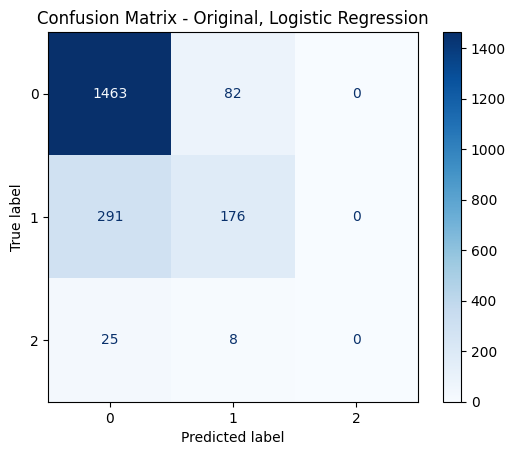

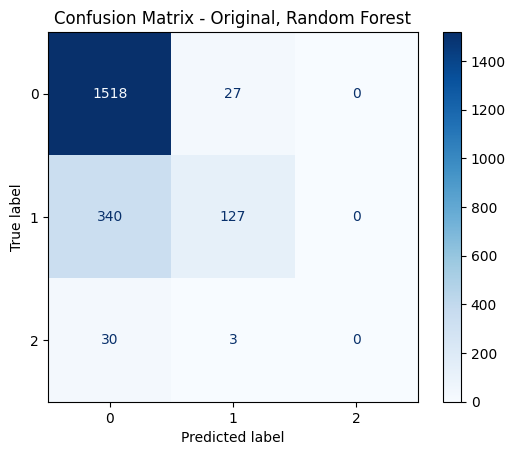

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:30:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


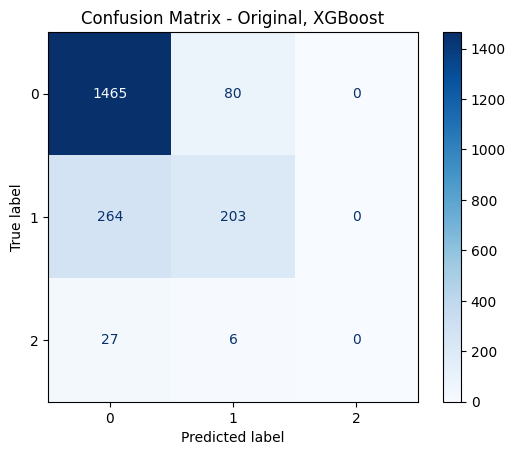

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 100
[LightGBM] [Info] Start training from score -0.280737
[LightGBM] [Info] Start training from score -1.476166
[LightGBM] [Info] Start training from score -4.118976


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


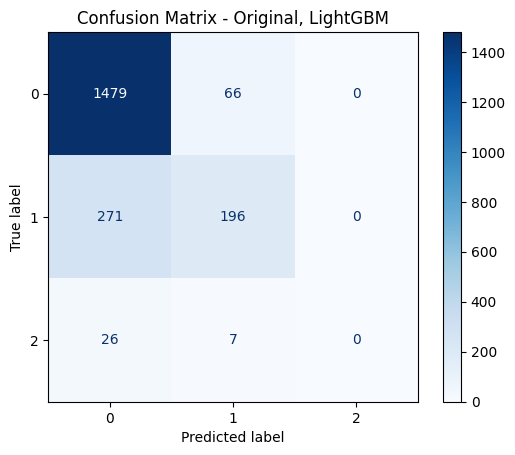

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


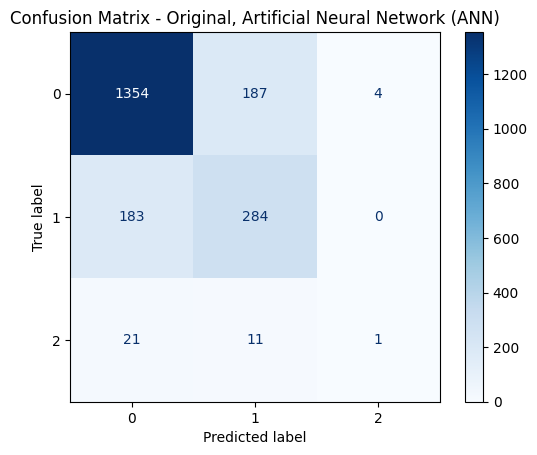

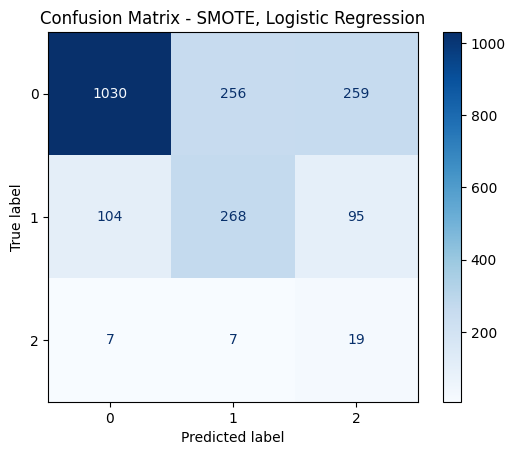

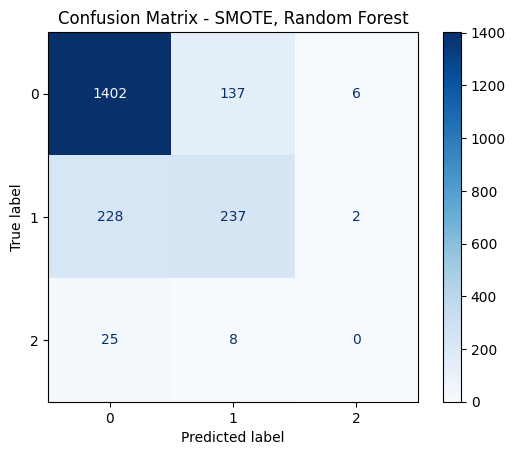

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


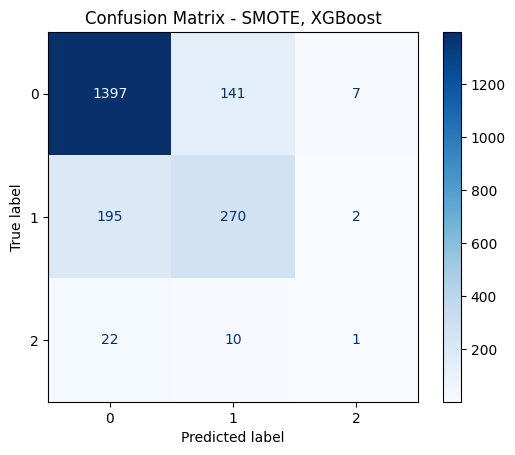

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


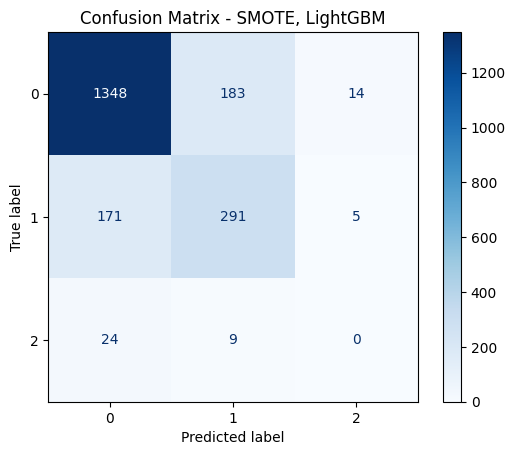

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


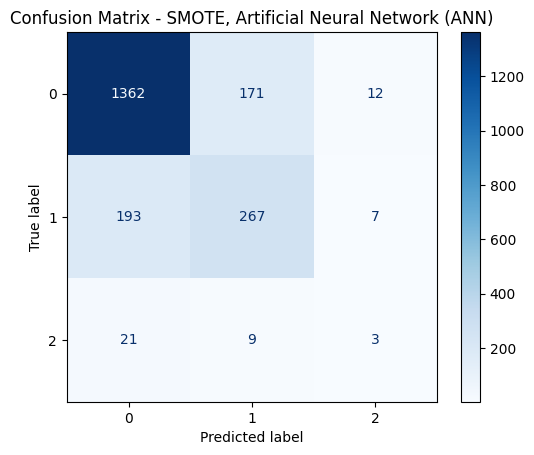

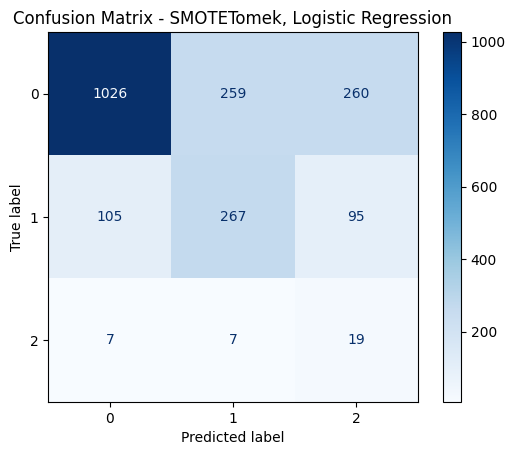

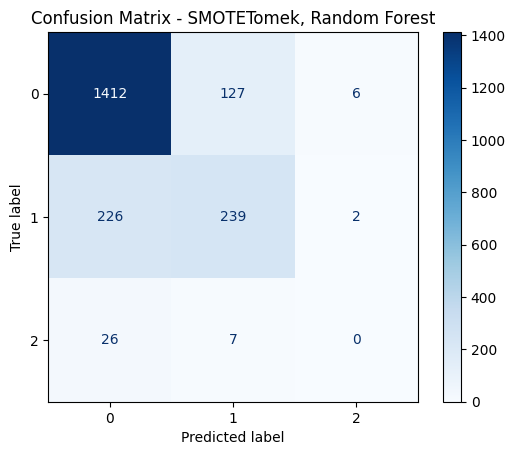

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:32:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


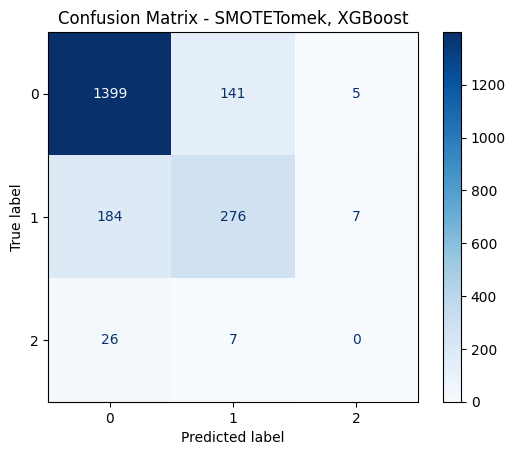

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 18525, number of used features: 100
[LightGBM] [Info] Start training from score -1.098774
[LightGBM] [Info] Start training from score -1.098774
[LightGBM] [Info] Start training from score -1.098288


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


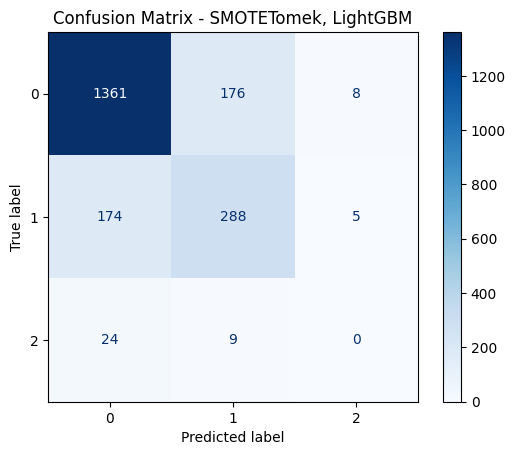

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


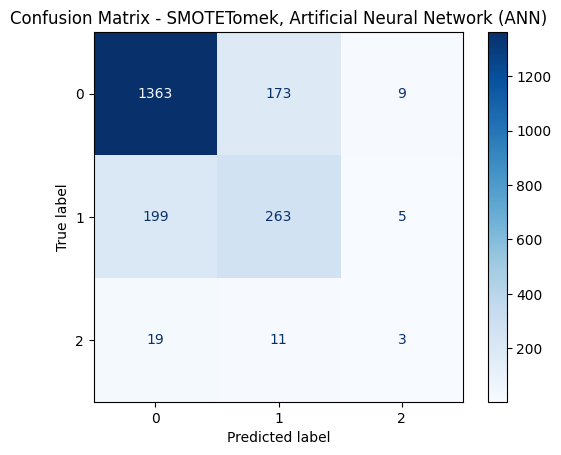

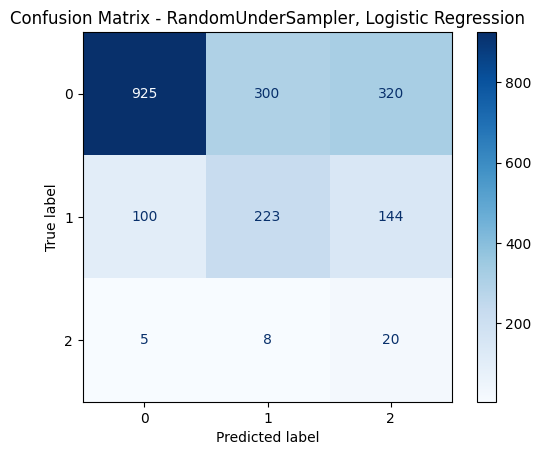

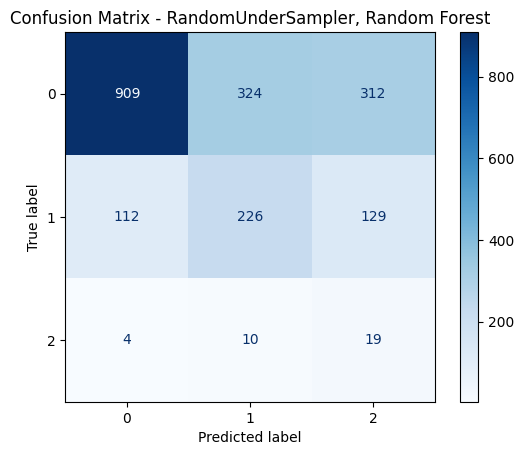

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:33:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


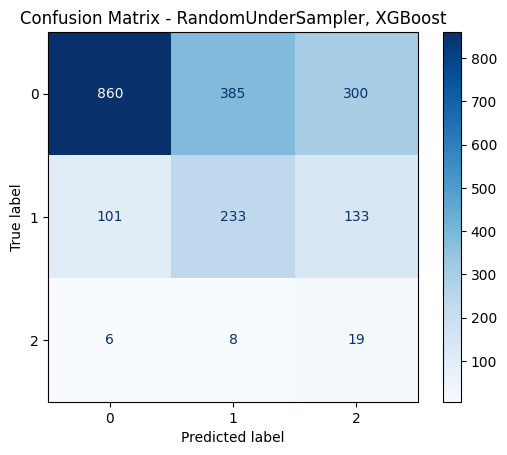

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13366
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


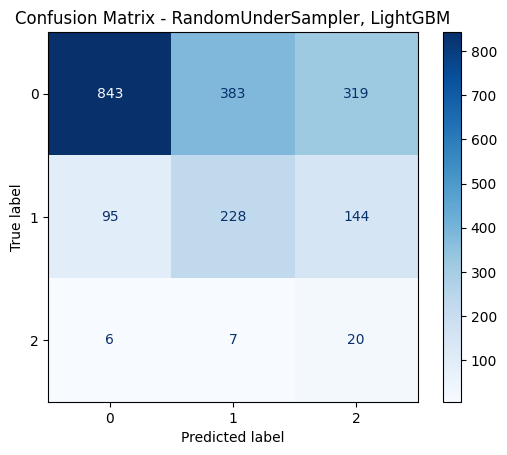

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


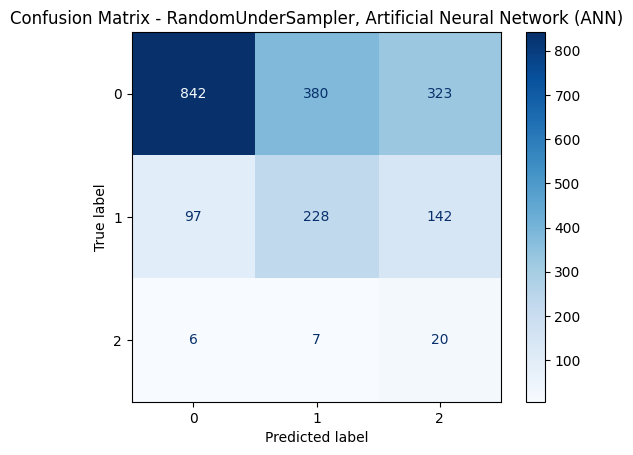

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ana kodunuzu (model eğitimi ve sonuç döngünüzü) tamamladıktan sonra ekleyin:
for method_name, (X_resampled, y_resampled) in resampling_methods.items():
    for model_name, model in models.items():
        # Model tekrar eğit (veya kodunuzda zaten eğitilen modeli burada yeniden kullanabilirsiniz)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)

        # Confusion matrix oluşturma
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix - {method_name}, {model_name}")
        plt.show()
